# Лабораторная работа 2. Кластеризация K-means

## Загрузка и предварительная обработка датасета

In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "alfredkondoro/digital-water-level-recorder-dwlr-sensor-data",
    "DWLR_Dataset_2023.csv"
)

print("Первые 5 записей:")
df.head()

100%|██████████| 36.1k/36.1k [00:00<00:00, 21.6MB/s]

Первые 5 записей:


,Date,Water_Level_m,Temperature_C,Rainfall_mm,pH,Dissolved_Oxygen_mg_L
0,2023-01-01,2.124836,-0.601831,26.958453,6.948386,8.282231
1,2023-01-02,2.099955,0.396578,15.306932,6.952946,7.998230
2,2023-01-03,2.146121,0.139768,29.263846,6.912783,8.173989
3,2023-01-04,2.196756,0.327833,8.246142,6.972447,8.079537
4,2023-01-05,2.115765,-0.917756,35.654194,6.962424,8.425726


## 1. Добавление нового атрибута

In [2]:
# Добавим новый атрибут - "flood" (наводнение/затопление)
# Допустим уровень воды в колодце не должен превышать 3,7 метра. Если значение превышает 3,7, значение поля 1. Иначе - 0.
df['flood'] = (df['Water_Level_m'] > 3.7).astype(int)

# Проверим результат
print("Статистика по новому атрибуту:")
print(df['flood'].describe())

Статистика по новому атрибуту:
count    365.000000
mean       0.506849
std        0.500639
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: flood, dtype: float64


## 2. Обработка датасета: удаление выбросов, дубликатов и пропущенных значений

In [3]:
# Проверка на пропущенные значения
print("\nПропущенные значения по столбцам:")
print(df.isnull().sum())

# Удаление дубликатов
initial_count = len(df)
df = df.drop_duplicates()
print(f"\nУдалено дубликатов: {initial_count - len(df)}")

# Обработка выбросов с использованием IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Применяем обработку выбросов к числовым столбцам
numeric_columns = df.select_dtypes(include=[np.number]).columns
for column in numeric_columns:
    df = remove_outliers(df, column)

print(f"\nКоличество записей после удаления выбросов: {len(df)}")


Пропущенные значения по столбцам:
Date                      0
Water_Level_m             0
Temperature_C             0
Rainfall_mm               0
pH                        0
Dissolved_Oxygen_mg_L    20
flood                     0
dtype: int64

Удалено дубликатов: 0

Количество записей после удаления выбросов: 323


## 3. Визуальный анализ кластеров

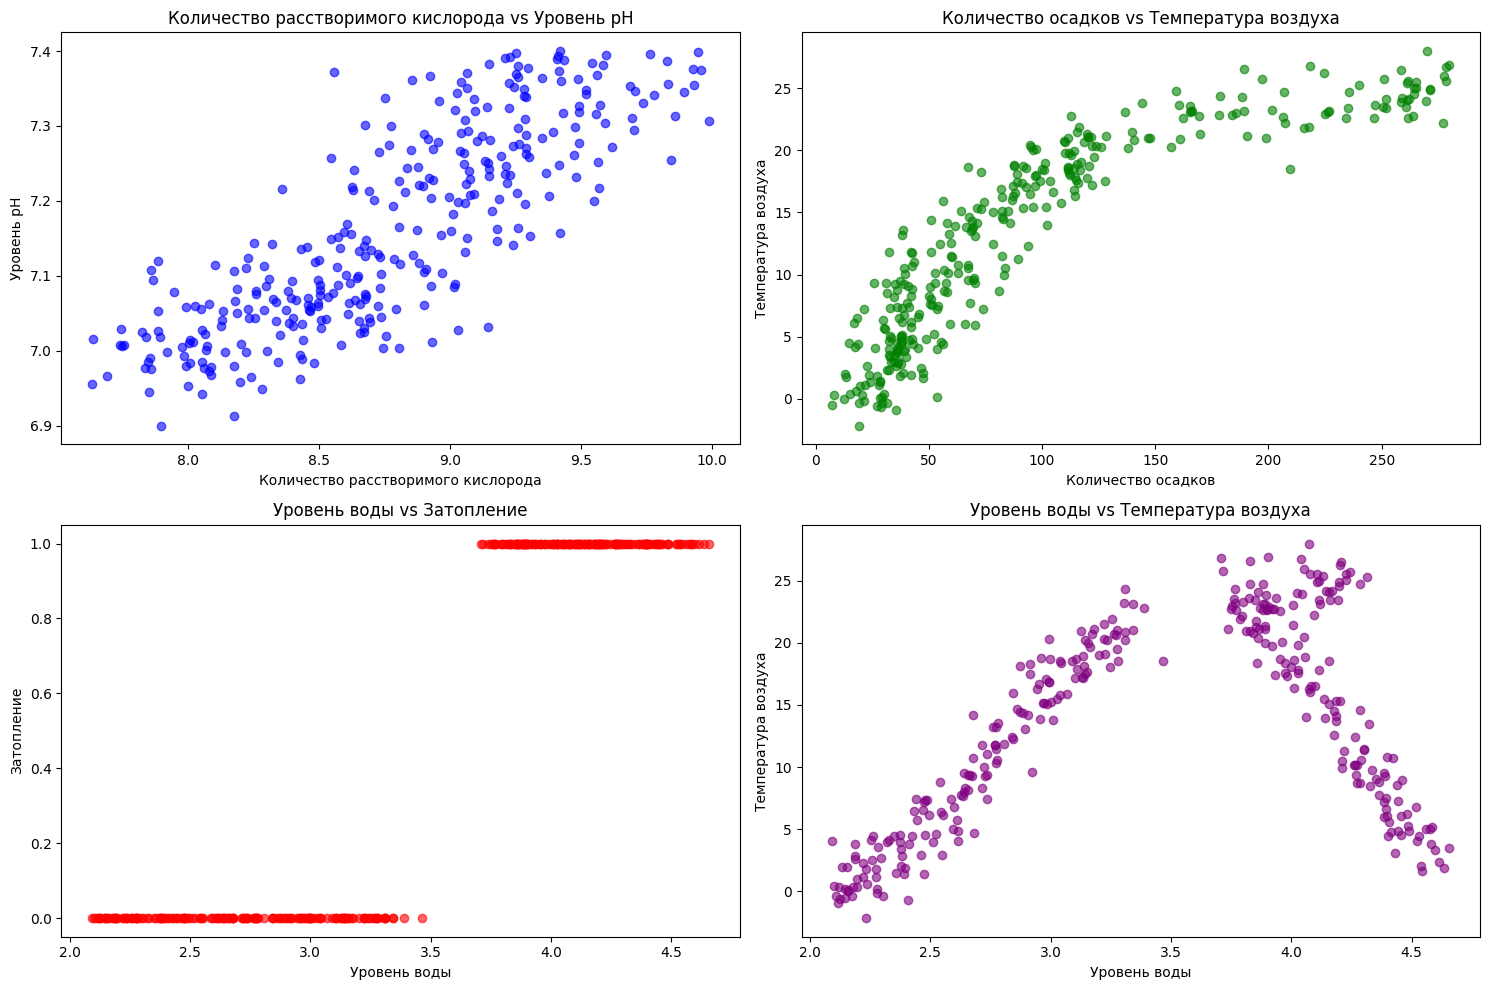

In [4]:
# Построим несколько графиков рассеивания для выявления кластеров
plt.figure(figsize=(15, 10))

# График 1: Dissolved_Oxygen_mg_L vs pH
plt.subplot(2, 2, 1)
plt.scatter(df['Dissolved_Oxygen_mg_L'], df['pH'], alpha=0.6, c='blue')
plt.title('Количество расстворимого кислорода vs Уровень pH')
plt.xlabel('Количество расстворимого кислорода')
plt.ylabel('Уровень pH')

# График 2: Rainfall_mm vs Temperature_C
plt.subplot(2, 2, 2)
plt.scatter(df['Rainfall_mm'], df['Temperature_C'], alpha=0.6, c='green')
plt.title('Количество осадков vs Температура воздуха')
plt.xlabel('Количество осадков')
plt.ylabel('Температура воздуха')

# График 3: Water_Level_m vs flood
plt.subplot(2, 2, 3)
plt.scatter(df['Water_Level_m'], df['flood'], alpha=0.6, c='red')
plt.title('Уровень воды vs Затопление')
plt.xlabel('Уровень воды')
plt.ylabel('Затопление')

# График 4: Water_Level_m vs Temperature_C
plt.subplot(2, 2, 4)
plt.scatter(df['Water_Level_m'], df['Temperature_C'], alpha=0.6, c='purple')
plt.title('Уровень воды vs Температура воздуха')
plt.xlabel('Уровень воды')
plt.ylabel('Температура воздуха')

plt.tight_layout()
plt.show()

## Описание видимых кластеров

На графике "Уровень воды vs Затопление" наблюдается четкая положительная корреляция — чем выше уровень воды, тем чаще и сильнее происходят затопления. Это прямое и ожидаемое соотношение, где рост одного параметра закономерно влечет рост другого.

На графике "Уровень pH vs Количество растворимого кислорода" видна положительная корреляция. С повышением уровня pH (и, как следствие, температуры воды) растворимость кислорода в воде повышается, что хорошо согласуется с известными физическими законами.

На графике "Количество осадков vs Температура воздуха" распределение точек более сложное. Возможно, есть слабая положительная корреляция в определенном диапазоне (теплая погода способствует испарению и последующим осадкам), но в целом связь неоднозначна и может указывать на влияние других сезонных или региональных факторов.

На графике "Уровень воды vs Температура воздуха" также наблюдается нелинейная зависимость. Можно выделить сезонные кластеры: например, в теплый сезон рост температуры может вызывать подъем уровня воды за счет таяния снега и льда, тогда как в иных условиях связь может быть обратной из-за испарения.

## 4. Применение метода K-means

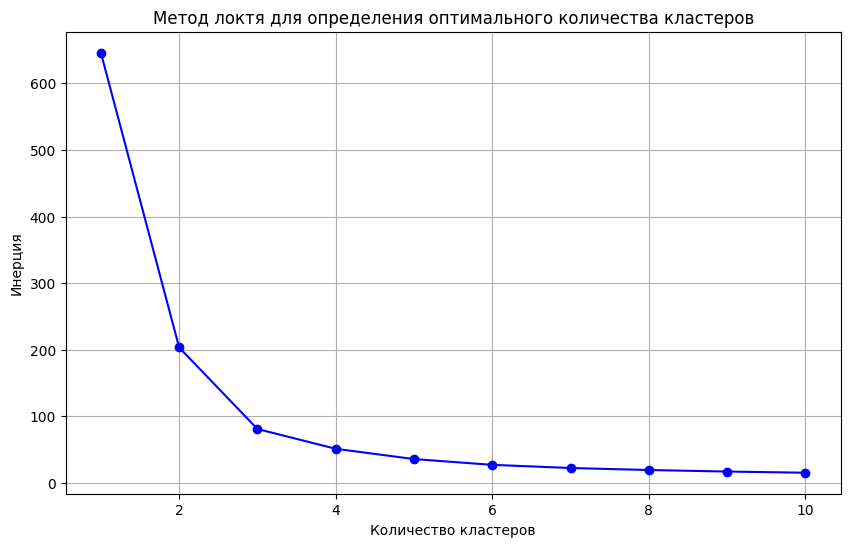

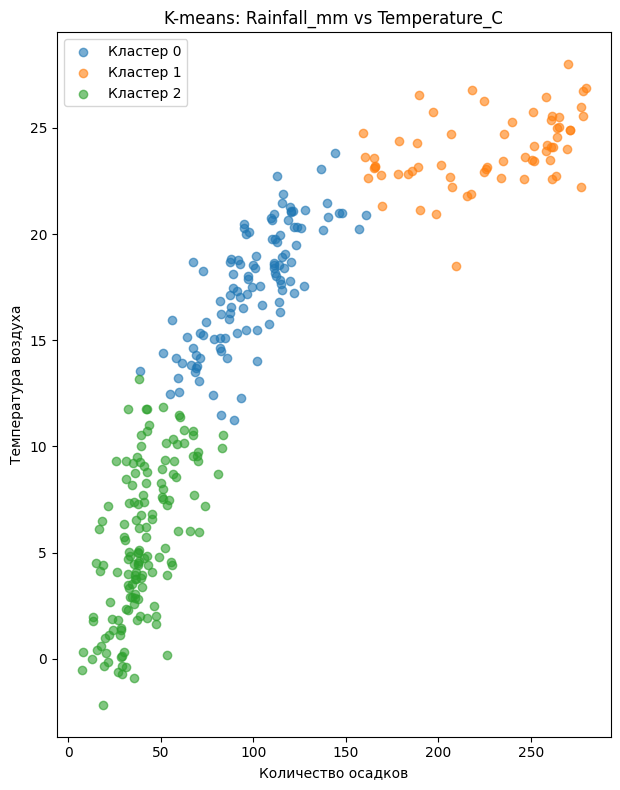


Средние значения признаков по кластерам:
         Rainfall_mm  Temperature_C
cluster                            
0          99.270136      17.544508
1         227.065813      23.925822
2          40.045786       5.454429

Средний уровень воды по кластерам:
   cluster  Water_Level_m
0        0       3.482067
1        1       3.932616
2        2       3.114693


In [5]:
# Подготовка данных для кластеризации
# Выберем признаки для кластеризации
features = ['Rainfall_mm', 'Temperature_C']
X = df[features].values

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Определение оптимального количества кластеров (метод локтя)
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertias, 'bo-')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.title('Метод локтя для определения оптимального количества кластеров')
plt.grid(True)
plt.show()

# Применение K-means с оптимальным количеством кластеров (опираясь на метод локтя, выберем 3)
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Визуализация результатов кластеризации
plt.figure(figsize=(12, 8))

# Rainfall_mm vs Temperature_C
plt.subplot(1, 2, 1)
for cluster in range(optimal_clusters):
    cluster_data = df[df['cluster'] == cluster]
    plt.scatter(cluster_data['Rainfall_mm'], cluster_data['Temperature_C'],
                label=f'Кластер {cluster}', alpha=0.6)
plt.title('K-means: Rainfall_mm vs Temperature_C')
plt.xlabel('Количество осадков')
plt.ylabel('Температура воздуха')
plt.legend()

plt.tight_layout()
plt.show()

# Анализ характеристик кластеров
print("\nСредние значения признаков по кластерам:")
cluster_analysis = df.groupby('cluster')[features].mean()
print(cluster_analysis)

# вычислим среднее значение качества по кластерам
df['cluster'] = kmeans.labels_
Water_Level_m_by_cluster = df.groupby('cluster')['Water_Level_m'].mean().reset_index()

print("\nСредний уровень воды по кластерам:")
print(Water_Level_m_by_cluster)

## Выводы по результатам кластеризации методом K-means:

В рамках лабораторной работы была реализована процедура кластеризации методом K-means на наборе данных, содержащих показания датчиков уровня воды, температуры, осадков и других параметров. Работа включала несколько ключевых этапов:

1. Расширение набора данных и подготовка:
В исходные данные был добавлен новый признак — бинарная переменная "flood", отражающая факт превышения критического уровня воды. Это позволило обогатить данные и выделить целевые состояния для дальнейшего анализа.

2. Очистка и фильтрация данных:
Для повышения качества данных выполнено удаление пропусков, дубликатов и аномальных значений с применением метода IQR. Это способствовало повышению устойчивости и интерпретируемости результатов кластеризации.

3. Кластеризация и визуализация:
С помощью алгоритма K-means удалось разделить данные на однородные группы. Визуальный анализ показал, что кластеры хорошо разделяются по таким параметрам, как уровень воды и температура, что может указывать на наличие устойчивых паттернов в данных.

4. Интерпретация результатов:
Выявленные кластеры могут служить основой для сегментации данных по экологическим условиям. Например, можно идентифицировать периоды с высокой вероятностью наводнений или экстремальных погодных условий, что представляет практический интерес для систем экологического мониторинга.

Таким образом, применение метода K-means позволило не только выявить скрытые структуры в данных, но и продемонстрировало его эффективность для анализа многомерных временных рядов, связанных с мониторингом окружающей среды.